In [2]:
import os
import cv2
import random
import numpy as np
import skimage
import umap
import hdbscan
import pandas as pd
import torch

from glob import glob
from collections import Counter
from tqdm.auto import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

In [ ]:
BATCH_SIZE = 8
SEED = 42

In [4]:
# https://huggingface.co/geolocal/StreetCLIP
# StreetCLIP is a robust foundation model for open-domain image geolocalization and other geographic and climate-related tasks.

clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP")
clip_model.to('cuda')
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

In [5]:
image_paths = sorted(glob('./db/train_gt/*.png'))

In [78]:
image_features = []
for i in tqdm(range(0,len(image_paths), BATCH_SIZE)):
    image_paths_batch = image_paths[i:i+BATCH_SIZE]
    images = [Image.open(image_path) for image_path in image_paths_batch]
    pixel_values = clip_processor.image_processor(images=images, return_tensors='pt')['pixel_values'].to('cuda')
    with torch.no_grad():
        image_features_row = clip_model.get_image_features(pixel_values).cpu().numpy()
    image_features.append(image_features_row)

  0%|          | 0/7401 [00:00<?, ?it/s]

In [79]:
train_embeddings = np.vstack(image_features)

In [80]:
train_embeddings = normalize(train_embeddings, norm="l2")

In [81]:
np.save('./JiSung/train_embeddings', train_embeddings)
# train_embeddings = np.load('./preproc/train_embeddings.npy')

In [82]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=SEED,
).fit_transform(train_embeddings)

/home/team2/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/team2/anaconda3/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


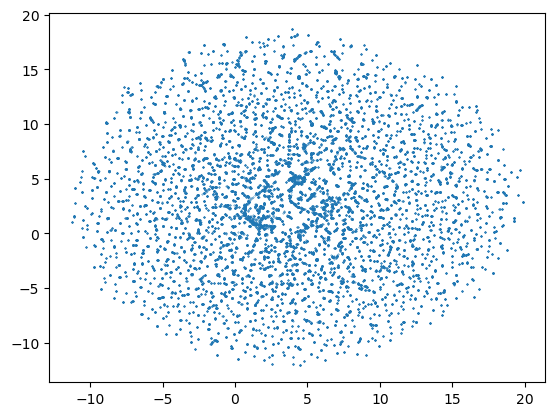

In [83]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [84]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

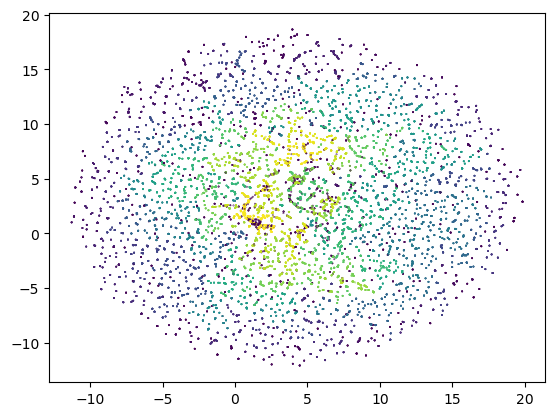

In [85]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=labels, s=0.1)

In [17]:
len(set(labels)), sum(labels==-1)

(2469, 2238)

In [86]:
counter = Counter([label for label in labels if label!=-1])

In [88]:
min(counter.values()), np.median(list(counter.values())), max(counter.values())

(5, 10.0, 81)

In [ ]:
print('label is 0')
for image_path in np.array(image_paths)[labels==0]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
print('label is 1')
for image_path in np.array(image_paths)[labels==1]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

"print('label is 0')\nfor image_path in np.array(image_paths)[labels==0]:\n    image = Image.open(image_path)\n    plt.imshow(image)\n    plt.show()\nprint('label is 1')\nfor image_path in np.array(image_paths)[labels==1]:\n    image = Image.open(image_path)\n    plt.imshow(image)\n    plt.show()"

In [90]:
train_df = pd.DataFrame(columns=['image','label'])

In [91]:
train_df['image'] = [os.path.basename(image_path) for image_path in image_paths]
train_df['label'] = labels

In [ ]:
train_df.to_csv('db/aug/open/jisung/train_preproc.csv', index=False)

In [93]:
test_image_paths = sorted(glob('./db/test_input//*.png'))

In [94]:
test_df = pd.DataFrame(columns=['image'])

In [95]:
test_df['image'] = [os.path.basename(image_path) for image_path in test_image_paths]

In [1]:
test_df.to_csv('./JiSung/test_preproc.csv', index=False)

NameError: name 'test_df' is not defined

In [ ]:
#pip install polygenerator lightning segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ec118a90e86a1c85d93539dfa9ef90ed5f9a6940421b23a01a57f092d3fa8ddb
  Stored in directory: /home/team2/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=828483c21c4e12c4e914a15af41c74b6da76f5753011ddd03ecfdc520f5f57f4
  Stored in directory: /home/team2/.cache/pip/wheels/4c/01/56/40a48f75dbdfe167a0cb70d3b48913369a00ec5c4e9fed5f2b
Successfully built effici

In [1]:
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
def get_input_image(image, min_polygon_bbox_size=50):
    width, height = image.size
    while True:
        bbox_x1 = random.randint(0, width-min_polygon_bbox_size)
        bbox_y1 = random.randint(0, height-min_polygon_bbox_size)
        bbox_x2 = random.randint(bbox_x1, width)  # Ensure width > 10
        bbox_y2 = random.randint(bbox_y1, height)  # Ensure height > 10
        if (bbox_x2-bbox_x1)<min_polygon_bbox_size or (bbox_y2-bbox_y1)<min_polygon_bbox_size:
            continue
        
        mask_bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
        mask_width = bbox_x2-bbox_x1
        mask_height = bbox_y2-bbox_y1
    
        num_points = random.randint(3,20)
        polygon_func = random.choice([
            random_polygon,
            random_star_shaped_polygon,
            random_convex_polygon
        ])
        polygon = polygon_func(num_points=num_points) #scaled 0~1
        polygon = [(round(r*mask_width), round(c*mask_height)) for r,c in polygon]
        polygon_mask = skimage.draw.polygon2mask((mask_width, mask_height), polygon)
        if np.sum(polygon_mask)>(min_polygon_bbox_size//2)**2:
            break
    full_image_mask = np.zeros((width, height), dtype=np.uint8)
    full_image_mask[bbox_x1:bbox_x2, bbox_y1:bbox_y2] = polygon_mask
    
    image_gray = image.convert('L')
    image_gray_array = np.array(image_gray)  # Convert to numpy array for manipulation
    random_color = random.randint(0, 255)  # Random grayscale color
    image_gray_array[full_image_mask == 1] = random_color
    image_gray_masked = Image.fromarray(image_gray_array)

    return {
        'image_gt':image,
        'mask':full_image_mask,
        'image_gray':image_gray,
        'image_gray_masked':image_gray_masked
    }

In [4]:
def get_ssim_score(true, pred):
    # 전체 RGB 이미지를 사용해 SSIM 계산 (channel_axis=-1)
    ssim_value = ski_ssim(true, pred, channel_axis=-1, data_range=pred.max() - pred.min())
    return ssim_value

def get_masked_ssim_score(true, pred, mask):
    # 손실 영역의 좌표에서만 RGB 채널별 픽셀 값 추출
    true_masked_pixels = true[mask > 0]
    pred_masked_pixels = pred[mask > 0]
    
    # 손실 영역 픽셀만으로 SSIM 계산 (채널축 사용)
    ssim_value = ski_ssim(
        true_masked_pixels, 
        pred_masked_pixels, 
        channel_axis=-1, 
        data_range=pred.max() - pred.min()
    )
    return ssim_value

def get_histogram_similarity(true, pred, cvt_color=cv2.COLOR_RGB2HSV):
    # BGR 이미지를 HSV로 변환
    true_hsv = cv2.cvtColor(true, cvt_color)
    pred_hsv = cv2.cvtColor(pred, cvt_color)

    # H 채널에서 히스토그램 계산 및 정규화
    hist_true = cv2.calcHist([true_hsv], [0], None, [180], [0, 180])
    hist_pred = cv2.calcHist([pred_hsv], [0], None, [180], [0, 180])
    hist_true = cv2.normalize(hist_true, hist_true).flatten()
    hist_pred = cv2.normalize(hist_pred, hist_pred).flatten()

    # 히스토그램 간 유사도 계산 (상관 계수 사용)
    similarity = cv2.compareHist(hist_true, hist_pred, cv2.HISTCMP_CORREL)
    return similarity

In [5]:
SEED=42
N_SPLIT=5
BATCH_SIZE=16
IMAGE_PREPROC_MEAN=0.5
IMAGE_PREPROC_STD=0.225
MIN_POLYGON_BBOX_SIZE = 50

In [43]:
TRAIN_DATA_DIR='./db/train_gt'
VALID_DATA_DIR=f'./JiSung/db/valid_input/{SEED=}-{MIN_POLYGON_BBOX_SIZE=}'
TEST_DATA_DIR='./db/test_input'
SUBMISSON_DATA_DIR='./JiSung/sub1'
EXPERIMENT_NAME='baseline(4)'

In [7]:
L.seed_everything(SEED)

Seed set to 42


42

In [8]:
train_df = pd.read_csv('./JiSung/train_preproc.csv')
test_df = pd.read_csv('./JiSung/test_preproc.csv')

In [ ]:
os.makedirs(VALID_DATA_DIR, exist_ok=True)
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = train_df.iloc[idx, 0]
    img_path = os.path.join(TRAIN_DATA_DIR, img_path)
    save_image_name = os.path.basename(img_path).replace('TRAIN', 'VALID').replace('png','npy')
    save_image_path = f'{VALID_DATA_DIR}/{save_image_name}'
    if os.path.exists(save_image_path):
        continue
    image = Image.open(img_path)
    valid_input_image = get_input_image(image, MIN_POLYGON_BBOX_SIZE)
    np.save(save_image_path, valid_input_image)

"os.makedirs(VALID_DATA_DIR, exist_ok=True)\nfor idx, row in tqdm(train_df.iterrows(), total=len(train_df)):\n    img_path = train_df.iloc[idx, 0]\n    img_path = os.path.join(TRAIN_DATA_DIR, img_path)\n    save_image_name = os.path.basename(img_path).replace('TRAIN', 'VALID').replace('png','npy')\n    save_image_path = f'{VALID_DATA_DIR}/{save_image_name}'\n    if os.path.exists(save_image_path):\n        continue\n    image = Image.open(img_path)\n    valid_input_image = get_input_image(image, MIN_POLYGON_BBOX_SIZE)\n    np.save(save_image_path, valid_input_image)"

In [9]:
train_df_outlier = train_df[train_df['label']==-1]
train_df = train_df[train_df['label']!=-1]

In [10]:
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=SEED)

In [11]:
for fold_idx, (train_indices, valid_indices) in enumerate(kf.split(train_df['image'], train_df['label'])):
    train_fold_df = train_df.iloc[train_indices].reset_index(drop=True)
    valid_fold_df = train_df.iloc[valid_indices].reset_index(drop=True)
    valid_fold_df['image'] = valid_fold_df['image'].apply(lambda x: x.replace('TRAIN', 'VALID').replace('png', 'npy'))
    valid_fold_df = valid_fold_df.drop_duplicates('label') # for fast validation
    # train_fold_df = pd.concat([train_fold_df,train_df_outlier],axis=0).reset_index(drop=True)
    break

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, df, data_dir='./db/train_gt', mode='train', min_polygon_bbox_size=MIN_POLYGON_BBOX_SIZE):
        self.df = df
        self.data_dir = data_dir
        self.mode = mode
        self.min_polygon_bbox_size = min_polygon_bbox_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.df.iloc[idx, 0]  # Assuming first column is the path
        img_path = os.path.join(self.data_dir, img_path)
        
        # Apply augmentation if in training mode
        if self.mode == 'train':
            image = Image.open(img_path)
            image_input = get_input_image(image, self.min_polygon_bbox_size)
            return image_input

        elif self.mode == 'valid':
            image_input = self.load_input_image(img_path)
            return image_input
        elif self.mode == 'test':
            image = Image.open(img_path)
            return {
                'image_gray_masked':image
            }

    def load_input_image(self, img_input_path):
        image_input = np.load(img_input_path, allow_pickle=True)
        return image_input.item()
    

In [13]:
train_dataset = CustomImageDataset(train_fold_df, data_dir=TRAIN_DATA_DIR, mode='train')
valid_dataset = CustomImageDataset(valid_fold_df, data_dir=VALID_DATA_DIR, mode='valid')
test_dataset = CustomImageDataset(test_df, data_dir=TEST_DATA_DIR, mode='test')

In [14]:
for idx, data in tqdm(enumerate(valid_dataset)):
    break

0it [00:00, ?it/s]

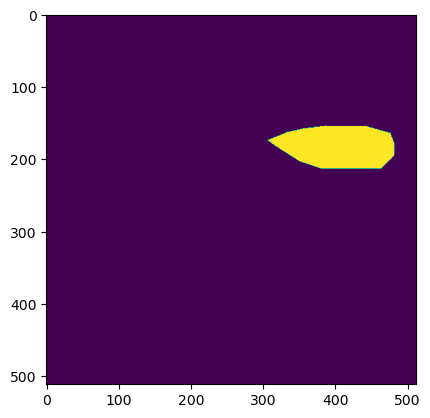

In [27]:
plt.imshow(data['mask'])

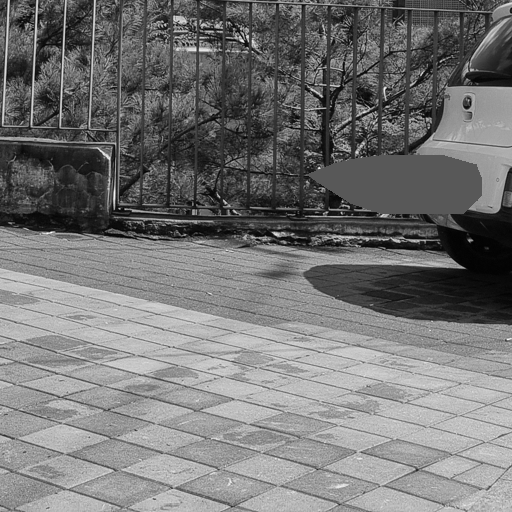

In [15]:
data['image_gray_masked']

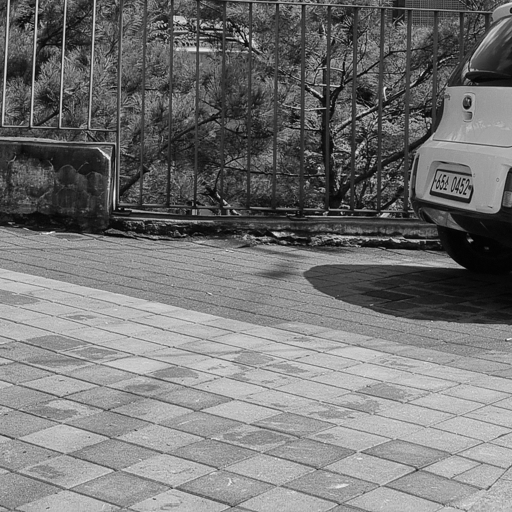

In [29]:
data['image_gray']

In [ ]:
data['image_gt']

In [16]:
class CollateFn:
    def __init__(self, mean=IMAGE_PREPROC_MEAN, std=IMAGE_PREPROC_STD, mode='train'):
        self.mode = mode
        self.mean = mean
        self.std = std

    def __call__(self, examples):
        if self.mode =='train' or self.mode=='valid':
            # Initialize lists to store each component of the batch
            masks= []
            images_gray = []
            images_gray_masked = []
            images_gt = []
    
            for example in examples:
                # Assuming each example is a dictionary with keys 'mask', 'image_gray', 'image_gray_masked', 'image_gt'
                masks.append(example['mask'])
                images_gray.append(self.normalize_image(example['image_gray']))
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
                images_gt.append(self.normalize_image(np.array(example['image_gt'])))

            return {
                'masks': torch.from_numpy(np.stack(masks)).long(),
                'images_gray': torch.from_numpy(np.stack(images_gray)).unsqueeze(1).float(),
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
                'images_gt': torch.from_numpy(np.stack(images_gt)).permute(0,3,1,2).float()
            }

        elif self.mode == 'test':
            images_gray_masked = []
            for example in examples:
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
            return {
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
            }

    def normalize_image(self, image):
        return (np.array(image)/255-self.mean)/self.std

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFn(mode='train'))
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=CollateFn(mode='valid'))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=CollateFn(mode='test'))

In [19]:
# 1. Weighted Ensemble 클래스
class WeightedEnsemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.ones(len(models)) / len(models))  # 초기 가중치 설정

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.sum(
            torch.stack(outputs) * F.softmax(self.weights, dim=0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1),
            dim=0
        )

In [20]:
# 2. Hybrid Restoration Model 클래스
class HybridRestorationModel(nn.Module):
    def __init__(self, restoration_models, colorization_models):
        super().__init__()
        self.restoration_models = nn.ModuleList(restoration_models)
        self.colorization_models = nn.ModuleList(colorization_models)

    def forward(self, x):
        # 복원 모델 앙상블
        restored_outputs = [model(x) + x for model in self.restoration_models]
        restored = torch.mean(torch.stack(restored_outputs), dim=0)

        # 색상화 모델 앙상블
        colored_outputs = [model(restored) for model in self.colorization_models]
        colored = torch.mean(torch.stack(colored_outputs), dim=0)

        return restored, colored


In [ ]:
# 6. LitIRModel 수정
class LitHybridIRModel(L.LightningModule):
    def __init__(self, hybrid_model, image_mean=IMAGE_PREPROC_MEAN, image_std=IMAGE_PREPROC_STD):
        super().__init__()
        self.hybrid_model = hybrid_model
        self.image_mean = image_mean
        self.image_std = image_std

    def forward(self, images_gray_masked):
        restored, colored = self.hybrid_model(images_gray_masked)
        return restored, colored

    def unnormalize(self, output, round=False):
        image_restored = ((output * self.image_std + self.image_mean) * 255).clamp(0, 255)
        if round:
            image_restored = torch.round(image_restored)
        return image_restored

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-4)

    
    def training_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gray, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gray'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        
        loss_pixel_gray = F.l1_loss(images_gray, images_gray_restored, reduction='mean') * 0.5 + F.mse_loss(images_gray, images_gray_restored, reduction='mean') * 0.5
        loss_pixel = F.l1_loss(images_gt, images_restored, reduction='mean') * 0.5 + F.mse_loss(images_gt, images_restored, reduction='mean') * 0.5
        loss = loss_pixel_gray * 0.5 + loss_pixel * 0.5

        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.log("train_loss_pixel_gray", loss_pixel_gray, on_step=True, on_epoch=False)
        self.log("train_loss_pixel", loss_pixel, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_gt, images_restored = self.unnormalize(images_gt, round=True), self.unnormalize(images_restored, round=True)
        masks_np = masks.detach().cpu().numpy()
        images_gt_np = images_gt.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        total_ssim_score = 0
        masked_ssim_score = 0
        hist_sim_score = 0
        for image_gt_np, image_restored_np, mask_np in zip(images_gt_np, images_restored_np, masks_np):
            total_ssim_score += get_ssim_score(image_gt_np, image_restored_np) / len(images_gt)
            masked_ssim_score += get_masked_ssim_score(image_gt_np, image_restored_np, mask_np)/ len(images_gt)
            hist_sim_score += get_histogram_similarity(image_gt_np, image_restored_np, cv2.COLOR_RGB2HSV)/ len(images_gt)
        score = total_ssim_score * 0.2 + masked_ssim_score * 0.4 + hist_sim_score * 0.4
        self.log(f"val_score", score, on_step=False, on_epoch=True)
        self.log(f"val_total_ssim_score", total_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_masked_ssim_score", masked_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_hist_sim_score", hist_sim_score, on_step=False, on_epoch=True)
        return score

    def predict_step(self, batch, batch_idx):
        images_gray_masked = batch['images_gray_masked']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_restored = self.unnormalize(images_restored, round=True)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        return images_restored_np

In [ ]:

model_1 = [
    smp.Unet(encoder_name="efficientnet-b0", encoder_weights="imagenet", in_channels=1, classes=1),
    smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet", in_channels=1, classes=1),
    smp.MAnet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=1)
]

model_2 = [
    smp.Unet(encoder_name="efficientnet-b1", encoder_weights="imagenet", in_channels=1, classes=3),
    smp.FPN(encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=3),
    smp.DeepLabV3Plus(encoder_name="efficientnet-b2", encoder_weights="imagenet", in_channels=1, classes=3)
]

In [32]:
# 5. HybridRestorationModel 통합
hybrid_model = HybridRestorationModel(
    restoration_models=model_1,
    colorization_models=model_2
)


lit_ir_model = LitHybridIRModel(hybrid_model)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_score',
    mode='max',
    dirpath='./JiSung/checkpoint3/',
    filename=f'smp-unet-hybrede-{fold_idx=}-{SEED=}'+'-{epoch:02d}-{val_score:.4f}',
    save_top_k=1,
    save_weights_only=True,
    verbose=True
)
earlystopping_callback = EarlyStopping(monitor="val_score", mode="max", patience=3)

In [35]:
trainer = L.Trainer(max_epochs=40, precision='bf16-mixed', callbacks=[checkpoint_callback, earlystopping_callback], detect_anomaly=False)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [36]:
trainer.fit(lit_ir_model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | hybrid_model | HybridRestorationModel | 203 M  | train
----------------------------------------------------------------
203 M     Trainable params
0         Non-trainable params
203 M     Total params
815.290   Total estimated model params size (MB)
1942      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 1374: 'val_score' reached 0.51394 (best 0.51394), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=00-val_score=0.5139.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 2748: 'val_score' reached 0.56000 (best 0.56000), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=01-val_score=0.5600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 4122: 'val_score' reached 0.58145 (best 0.58145), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=02-val_score=0.5815.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 5496: 'val_score' reached 0.59548 (best 0.59548), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=03-val_score=0.5955.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 6870: 'val_score' reached 0.60484 (best 0.60484), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=04-val_score=0.6048.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 8244: 'val_score' reached 0.60527 (best 0.60527), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=05-val_score=0.6053.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 9618: 'val_score' reached 0.61654 (best 0.61654), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=06-val_score=0.6165.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 10992: 'val_score' reached 0.62024 (best 0.62024), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=07-val_score=0.6202.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 12366: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 13740: 'val_score' reached 0.63110 (best 0.63110), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=09-val_score=0.6311.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 15114: 'val_score' reached 0.63741 (best 0.63741), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=10-val_score=0.6374.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 16488: 'val_score' reached 0.63811 (best 0.63811), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=11-val_score=0.6381.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 17862: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 19236: 'val_score' reached 0.64247 (best 0.64247), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=13-val_score=0.6425.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 20610: 'val_score' reached 0.64554 (best 0.64554), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=14-val_score=0.6455.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 21984: 'val_score' reached 0.65108 (best 0.65108), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=15-val_score=0.6511.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 23358: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 24732: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 26106: 'val_score' reached 0.65463 (best 0.65463), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=18-val_score=0.6546.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 27480: 'val_score' reached 0.65614 (best 0.65614), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=19-val_score=0.6561.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 28854: 'val_score' reached 0.66201 (best 0.66201), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=20-val_score=0.6620.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 30228: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 31602: 'val_score' reached 0.66233 (best 0.66233), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=22-val_score=0.6623.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 32976: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 34350: 'val_score' reached 0.66367 (best 0.66367), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=24-val_score=0.6637.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 35724: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 37098: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 38472: 'val_score' reached 0.66411 (best 0.66411), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=27-val_score=0.6641.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 39846: 'val_score' reached 0.66419 (best 0.66419), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=28-val_score=0.6642.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 41220: 'val_score' reached 0.66704 (best 0.66704), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=29-val_score=0.6670.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 42594: 'val_score' reached 0.66810 (best 0.66810), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=30-val_score=0.6681.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 43968: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 45342: 'val_score' reached 0.67390 (best 0.67390), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=32-val_score=0.6739.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 46716: 'val_score' reached 0.67538 (best 0.67538), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=33-val_score=0.6754.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 48090: 'val_score' reached 0.67606 (best 0.67606), saving model to '/home/team2/deepLearing/JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=34-val_score=0.6761.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 49464: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 50838: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 52212: 'val_score' was not in top 1


In [40]:
lit_ir_model = LitHybridIRModel.load_from_checkpoint(
    checkpoint_path='./JiSung/checkpoint3/smp-unet-hybrede-fold_idx=0-SEED=42-epoch=34-val_score=0.6761.ckpt',
    hybrid_model=hybrid_model
)


In [41]:
predictions = trainer.predict(lit_ir_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/team2/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [42]:
predictions = np.concatenate(predictions)

In [44]:
submission_dir = os.path.join(SUBMISSON_DATA_DIR, EXPERIMENT_NAME)
submission_file = f'{SUBMISSON_DATA_DIR}/{EXPERIMENT_NAME}.zip'
os.makedirs(submission_dir, exist_ok=True)

In [45]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_pred = Image.fromarray(predictions[idx])
    image_pred.save(os.path.join(submission_dir, row['image']), "PNG")

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Step 3: Compress the directory into a ZIP file using glob
with zipfile.ZipFile(submission_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in glob(f"{submission_dir}/*.png"):
        arcname = os.path.relpath(file_path, submission_dir)
        zipf.write(file_path, arcname)